In [ ]:
# import gc
# import torch
# gc.collect()
# torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Fri May 28 08:45:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2

import pandas as pd
import shutil

from scipy.ndimage import distance_transform_edt as eucl_distance
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union, cast
from functools import partial, reduce
from operator import itemgetter, mul
from torch import Tensor, einsum

### Please enter the parameters

In [4]:
# Dataset options:
#    - Hippocampus-2D
#    - Heart-2D
#    - Heart-2D_onlyimage
dataset = 'Heart-2D_onlyimage'

# Model options:
#    - U-Net
#    - Attention_U-Net
Model = 'U-Net'

# Loss options:
#    - GeneralizedDice
#    - CrossEntropy
#    - FocalLoss
Loss = 'CrossEntropy'

# Boundary_loss options:
#    - True
#    - False
Boundary_option = 'True'

n_epochs = 50

ALPHA = 0.01

In [1]:
if dataset == 'Hippocampus-2D':
    path = './Hippocampus-2D'
    K = 3
    # %cd '/content'
    ! gdown --id '1GyTS7KzudC9glm0KZr4qyU5Txfz2PI5c'
    ! unzip 'Hippocampus-2D.zip'
    path = 'Hippocampus-2D'
    batch_size = 8

elif dataset == 'Heart-2D':
    path = './Heart-2D'
    K = 2
    # %cd '/content'
    ! gdown --id '1VLE1H7IHhVaf04PzVV5yHXstey1ecz5L'
    ! unzip 'Heart-2D.zip'
    path = 'Heart-2D'
    batch_size = 8

elif dataset == 'Heart-2D_onlyimage':
    path = './Heart-2D_onlyimage'
    K = 2
    # %cd '/content'
    ! gdown --id '1wlXQlhQbpOf6T-su7e3X9vc-Xj_6kc_J'
    ! unzip 'Heart-2D_onlyimage.zip'
    path = 'Heart-2D_onlyimage'
    batch_size = 8

else:
    print('Such a dataset does not exist for these experiments')

set_classes = list(range(K))

### Functions

In [15]:
### asserts 

def sset(a, sub):
    return uniq(a).issubset(sub)  

def uniq(a):
    return set(torch.unique(a.cpu()).numpy())

def one_hot(t, axis=1):
    return simplex(t, axis) and sset(t, set_classes)  

def simplex(t, axis=1):                                                          
    _sum = cast(Tensor, t.sum(axis).type(torch.float32))                        
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)  

In [16]:
class Transforms():
  def __init__(self, resolution, K):

      self.K = K
      self.resolution = resolution
      self.encods = Encoding()

      self.image_transform = transforms.Compose([
            lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 
            lambda img: img[np.newaxis, ...], 
            lambda img: img / 255,  
            lambda img: torch.tensor(img, dtype=torch.float32)
      ])

      self.mask_transform = transforms.Compose([
            lambda img: img[...],
            lambda img: torch.tensor(img, dtype=torch.int64)[None, ...],
            partial(self.encods.one_hot_encoding, K=self.K),
            itemgetter(0)  
      ])


      self.dist_map_transform = transforms.Compose([
            self.mask_transform,
            lambda img: img.cpu().numpy(),
            partial(self.encods.dist_encoding, resolution=self.resolution),                   
            lambda img: torch.tensor(img, dtype=torch.float32) 
      ])
     

  def forward(self, img, transform_type):
        if transform_type == 'img':
          return self.image_transform(img)

        if transform_type == 'mask':
          return self.mask_transform(img)

        if transform_type == 'dist_map':
          return self.dist_map_transform(img)


In [17]:
class Encoding():
  def __init__(self):
      super().__init__()

  def one_hot_encoding(self, mask_input, K):
    assert sset(mask_input, list(range(K))), (uniq(mask_input), K)

    b, *img_shape = mask_input.shape  
    device = mask_input.device

    output = torch.zeros((b, K, *img_shape), dtype=torch.int64, device=device).scatter_(1, mask_input[:, None, ...], 1)
    
    assert output.shape == (b, K, *img_shape)
    assert one_hot(output)
    return output 

  def dist_encoding(self, mask, resolution, dtype=None):                                  
    assert one_hot(torch.tensor(mask), axis=0)                                   
    K = len(mask)                                                                

    output = np.zeros_like(mask, dtype=dtype)

    for k in range(K):
        posmask = mask[k].astype(np.bool)

        if posmask.any():                                                      
            negmask = ~posmask
            output[k] = eucl_distance(negmask, sampling=resolution) * negmask - (eucl_distance(posmask, sampling=resolution) - 1) * posmask
            # res1 = cv2.distanceTransform(np.array(negmask, dtype='uint8'), distanceType=cv2.DIST_L2, maskSize=5).astype(np.float32)
            # res2 = cv2.distanceTransform(np.array(posmask, dtype='uint8'), distanceType=cv2.DIST_L2, maskSize=5).astype(np.float32)
            # output[k] = res1 * negmask - (res2-1) * posmask  

    return output

In [18]:
class Boundary_Loss():
    def __init__(self, idc):
        self.idc = idc                                              

    def __call__(self, probs, dist_maps):
        assert simplex(probs)                                                    
        assert not one_hot(dist_maps)

        prob = probs[:, self.idc, ...].type(torch.float32)                        
        dist_map = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = einsum("bkwh,bkwh->bkwh", prob, dist_map)                           
        loss = multipled.mean()                                               
        return loss

BoundaryLoss = Boundary_Loss                                                   

In [19]:
def plotting(masks, K):
  fig, axs = plt.subplots(ncols=K, sharex=True, figsize=(15, 15))
  for i in range(K):
    axs[i].imshow(masks[i], cmap='seismic', interpolation='none')
    axs[i].title.set_text('Class: {}'.format(i))
  plt.show()
  

In [20]:
def plot_one_mask(masks, num_class):
  final_mask = np.zeros_like(masks[0])
  for i in range (num_class):
    final_mask[masks[i] > 0.3] = i
  
  plt.imshow(final_mask, cmap='seismic', interpolation='none')
  plt.show()

### Dataloader

In [21]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder, K):
        super(Dataset, self).__init__()
        
        self.K = K
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.images_names = np.sort(os.listdir(images_folder))
        self.masks_names = np.sort(os.listdir(masks_folder))
        self.transform = Transforms([1, 1], self.K)

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = cv2.imread(os.path.join(self.images_folder,
                                            self.images_names[idx]))   
        item_mask = cv2.imread(os.path.join(self.masks_folder,
                                              self.masks_names[idx]))
        item_mask = cv2.cvtColor(item_mask, cv2.COLOR_BGR2GRAY)
        
        SEED = np.random.randint(123456789)
        if self.transform is not None:
            random.seed(SEED)
            image_tensor = self.transform.forward(item_image, 'img')     
            one_hot_tensor = self.transform.forward(item_mask, 'mask')
            dist_map_tensor = self.transform.forward(item_mask, 'dist_map')
      

        return image_tensor, one_hot_tensor, dist_map_tensor

In [22]:
train_set = MyDataset(images_folder = path + '/train/img/', 
                      masks_folder = path + '/train/gt', K=K)


val_set = MyDataset(images_folder = path + '/val/img/', 
                      masks_folder = path + '/val/gt', K=K)

In [25]:
print(len(train_set.images_names))
print(len(train_set.masks_names))
print(len(val_set.images_names))
print(len(val_set.masks_names))

1622
1622
649
649


### Import files with losses and models

In [26]:
! git clone https://github.com/kaaeaate/BoundaryLossProject

fatal: destination path 'BoundaryLossProject' already exists and is not an empty directory.


In [27]:
## If you don't want to clone git repo, you can download needed files with code below

# ! gdown --id '1G-qIa21Ouxac0UNRRiO0v-Qo_HB_Oj2f'
# ! gdown --id '1YK1LRF9MesidzIZRSGkdshKdiZh2KsQT'
# ! gdown --id '16kzaMQteWcjqXbyZLWwNhCdQPzD2FawD'

In [28]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = batch_size
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1622, 'val': 649}

In [29]:
# See example of images

import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks, dist_map = next(iter(dataloaders['train']))

print('Image shape:', inputs.shape)
print('Mask shape:', masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

Image shape: torch.Size([8, 1, 128, 128])
Mask shape: torch.Size([8, 2, 128, 128])
0.0 0.8392157 0.0898413 0.1367945
0 1 0.5 0.5


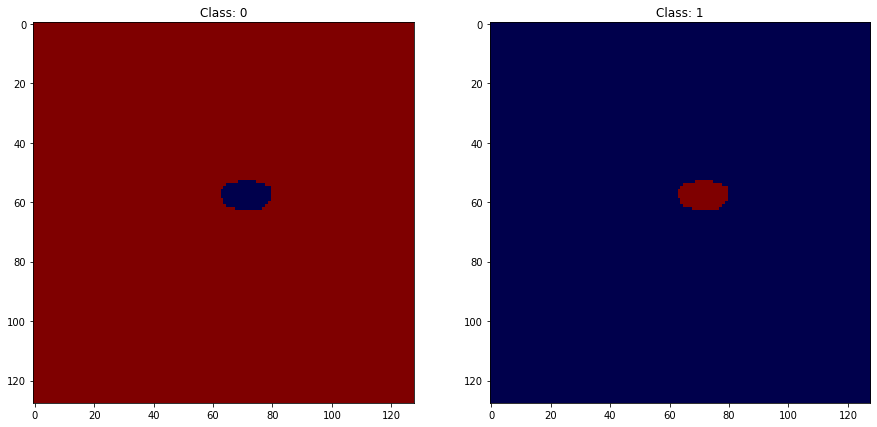

In [33]:
batch_number = 2
plotting(masks[batch_number], masks.shape[1])

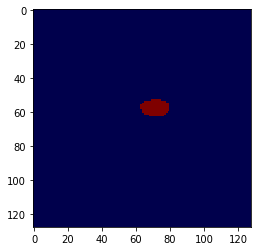

In [34]:
plot_one_mask(masks[batch_number], masks.shape[1])

# Start the model

In [23]:
import math
import copy
from collections import defaultdict
import torch.nn.functional as F  
from BoundaryLossProject.metrics import dice_loss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import numpy as np

In [24]:
import warnings
warnings.filterwarnings('ignore')

### Losses

In [25]:
class GeneralizedDice():
    def __init__(self, idc):
        self.idc = idc

    def __call__(self, probs, target):
        assert simplex(probs) and simplex(target)

        pc = probs[:, self.idc, ...].type(torch.float32)
        tc = target[:, self.idc, ...].type(torch.float32)

        w = 1 / ((einsum("bkwh->bk", tc).type(torch.float32) + 1e-10) ** 2)
        intersection = w * einsum("bkwh,bkwh->bk", pc, tc)
        union = w * (einsum("bkwh->bk", pc) + einsum("bkwh->bk", tc))

        divided = 1 - 2 * (einsum("bk->b", intersection) + 1e-10) / (einsum("bk->b", union) + 1e-10)

        loss = divided.mean()

        return loss

In [26]:
class CrossEntropy():
    def __init__(self, idc):
        self.idc: List[int] = idc

    def __call__(self, probs, target):
        assert simplex(probs) and simplex(target)

        log_p = (probs[:, self.idc, ...] + 1e-10).log()
        mask = cast(Tensor, target[:, self.idc, ...].type(torch.float32))

        loss = - einsum("bkwh,bkwh->", mask, log_p)
        loss /= mask.sum() + 1e-10

        return loss

In [27]:
class FocalLoss():
    def __init__(self, idc, gamma=2):
        self.idc = idc
        self.gamma = gamma

    def __call__(self, probs, target):
        assert simplex(probs) and simplex(target)

        masked_probs = probs[:, self.idc, ...]
        log_p = (masked_probs + 1e-10).log()
        mask = cast(Tensor, target[:, self.idc, ...].type(torch.float32))

        w = (1 - masked_probs)**self.gamma
        loss = - einsum("bkwh,bkwh,bkwh->", w, mask, log_p)
        loss /= mask.sum() + 1e-10

        return loss

In [28]:
class DiceLoss():
    def __init__(self, idc):
        self.idc = idc

    def __call__(self, probs, target):
        assert simplex(probs) and simplex(target)

        pc = probs[:, self.idc, ...].type(torch.float32)
        tc = target[:, self.idc, ...].type(torch.float32)

        intersection = einsum("bcwh,bcwh->bc", pc, tc)
        union = (einsum("bkwh->bk", pc) + einsum("bkwh->bk", tc))

        divided = torch.ones_like(intersection) - (2 * intersection + 1e-10) / (union + 1e-10)

        loss = divided.mean()

        return loss

### Metrics

In [31]:
def meta_dice(sum_str, label, pred, smooth = 1e-8) -> Tensor:
    assert label.shape == pred.shape
    assert one_hot(label)
    assert one_hot(pred)

    inter_size = einsum(sum_str, [intersection(label, pred)]).type(torch.float32)
    sum_sizes = (einsum(sum_str, [label]) + einsum(sum_str, [pred])).type(torch.float32)

    dices: Tensor = (2 * inter_size + smooth) / (sum_sizes + smooth)

    return dices


dice_coef = partial(meta_dice, "bk...->bk")


def intersection(a: Tensor, b: Tensor) -> Tensor:
    assert a.shape == b.shape
    assert sset(a, [0, 1])
    assert sset(b, [0, 1])

    res = a & b
    assert sset(res, [0, 1])

    return res


def union(a: Tensor, b: Tensor) -> Tensor:
    assert a.shape == b.shape
    assert sset(a, [0, 1])
    assert sset(b, [0, 1])

    res = a | b
    assert sset(res, [0, 1])

    return res


### Model

In [32]:
def target_to_one_mask(masks, num_class):
  final_mask = torch.zeros_like(masks[0])
  for i in range (num_class):
    final_mask[masks[i] > 0.5] = i
  return final_mask

In [33]:
def calc_loss(pred, target, dist_map_label, metrics, Loss, set_classes, K):

    if Loss == 'GeneralizedDice':
        loss = GeneralizedDice(idc=set_classes)
    elif Loss == 'CrossEntropy':
        loss = CrossEntropy(idc=set_classes)
    elif Loss == 'FocalLoss':  
        loss = FocalLoss(idc=set_classes, gamma=2)
    else:
        print('Such loss is not used in these experiments')

    pred_probs = F.softmax(pred, dim=1)
    main_loss = loss(pred_probs, target)

    if Boundary_option == 'True':
        alpha = ALPHA
        boundary_loss = BoundaryLoss(idc=set_classes) 
        bl_loss = boundary_loss(pred_probs, dist_map_label)  
        total_loss = main_loss + alpha * bl_loss
        metrics['boundary'] += bl_loss.data.cpu().numpy() * target.size(0)
    if Boundary_option == 'False':
        total_loss = main_loss 

    dice, dice2 = dice_loss(pred_probs, target)  
    metric_dice = DiceLoss(idc=set_classes)
    milti_dice = metric_dice(pred_probs, target)

    endoder = Encoding()
    new_mask = torch.zeros([target.shape[0], target.shape[2], target.shape[3]], dtype=torch.int64)
    for b in range(new_mask.shape[0]):
        new_mask[b] = target_to_one_mask(target[b], K)
    new_target = endoder.one_hot_encoding(new_mask, K)

    new_probs = torch.zeros([pred_probs.shape[0], pred_probs.shape[2], pred_probs.shape[3]], dtype=torch.int64)
    for b in range(new_probs.shape[0]):
        new_probs[b] = target_to_one_mask(pred_probs[b], K)
    new_preds = endoder.one_hot_encoding(new_probs, K)

    dsc = dice_coef(new_preds, new_target).mean()

    metrics['dice_binar'] += dice2.data.cpu().numpy() * target.size(0)
    metrics['old_DSC'] += dsc.data.cpu().numpy() * target.size(0)
    metrics['DSC'] += (1.- milti_dice.data.cpu().numpy()) * target.size(0)

    metrics[Loss] += main_loss.data.cpu().numpy() * target.size(0)
    metrics['loss'] += total_loss.data.cpu().numpy() * target.size(0)
    
    return total_loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

In [34]:
models_dir_loss = 'models_loss'
models_dir_dsc = 'models_dsc'
files_dir = "times_txt" 
logs_base_dir = './logs_' + dataset
os.makedirs(logs_base_dir, exist_ok=True)
os.makedirs(models_dir_loss, exist_ok=True)
os.makedirs(models_dir_dsc, exist_ok=True)
os.makedirs(files_dir, exist_ok=True)

In [35]:
def train_model(model, optimizer, scheduler, experiment_name, Loss, set_classes, K, num_epochs, weights):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dsc = 0.
    time_sum = 0.
    epoches = []
    
    writer = SummaryWriter(f'{logs_base_dir}/{experiment_name}')

    metrics_dice_train = []
    metrics_dice_val = []
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  
            else:
                model.eval()   

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels, dist_map_label in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device) 
                dist_map_label = dist_map_label.to(device)
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = F.softmax(outputs, dim=1) 
                    loss = calc_loss(outputs, labels, dist_map_label, metrics, Loss, set_classes, K)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            plot_one_mask(labels[0].detach().cpu().numpy(),K)
            plot_one_mask(pred[0].detach().cpu().numpy(),K)
            print_metrics(metrics, epoch_samples, phase)


            epoch_dice2 = metrics['old_DSC'] / epoch_samples
            writer.add_scalar(f'old_DSC_{phase}', epoch_dice2.item(), global_step=epoch)

            dsc_epoch = metrics['DSC'] / epoch_samples
            writer.add_scalar(f'DSC_{phase}', dsc_epoch.item(), global_step=epoch)


            main_loss = metrics[Loss] / epoch_samples
            writer.add_scalar(f'{Loss}_{phase}', main_loss.item(), global_step=epoch)

            if Boundary_option == 'True':
                epoch_boundary = metrics['boundary'] / epoch_samples
                writer.add_scalar(f'Boundary_value_{phase}', epoch_boundary.item(), global_step=epoch)


            epoch_dice = metrics['dice_binar'] / epoch_samples
            writer.add_scalar(f'old_DICE_binar_{phase}', epoch_dice.item(), global_step=epoch)

            epoch_loss = metrics['loss'] / epoch_samples
            writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)

            
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model with loss")
                best_loss = epoch_loss
                best_model_wts_loss = copy.deepcopy(model.state_dict())
                # load best model weights
                model.load_state_dict(best_model_wts_loss) 
                if weights == 'yes':
                    torch.save (model, f"{models_dir_loss}/loss_model_" + Model + '_' + '_' + dataset + '_' + Loss + '_' + Boundary_option  + ".pth")  #### save model

            if phase == 'val' and dsc_epoch > best_dsc:
                print("saving best model with dsc")
                best_dsc = dsc_epoch
                best_model_wts_dsc = copy.deepcopy(model.state_dict())
                print('Best val DSC: {:4f}'.format(best_dsc))
                # load best model weights
                model.load_state_dict(best_model_wts_dsc) 
                if weights == 'yes':
                    torch.save (model, f"{models_dir_dsc}/dsc_model_" + Model + '_' + '_' + dataset + '_' + Loss + '_' + Boundary_option  + ".pth")  #### save model

        time_elapsed = time.time() - since
        time_sum += time_elapsed
        file_name = "time_" + Model + '_' + '_' + dataset + '_' + Loss + '_' + Boundary_option 
        with open(f"{files_dir}/{file_name}.txt","a") as the_file:
            the_file.write('Epoch {}/{}:'.format(epoch, num_epochs - 1) + '  ' + str('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))+'\n')

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val DSC: {:4f}'.format(best_dsc))

    with open(f"{files_dir}/{file_name}.txt","a") as the_file:
        the_file.write('Total time:' + '  ' + str('{:.0f}m {:.0f}s'.format(time_sum // 60, time_sum % 60))+'\n')

    return model

In [36]:
%load_ext tensorboard
logs_base_dir = './logs_' + dataset
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 128), started 0:13:25 ago. (Use '!kill 128' to kill it.)

<IPython.core.display.Javascript object>

# Run model

In [2]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from BoundaryLossProject import unet
from BoundaryLossProject import  attention_unet
import helper
from datetime import datetime 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = K

if Model == 'U-Net':
    model = unet.UNet(1, num_class).to(device)
elif Model == 'Attention_U-Net':
    model = attention_unet.AttU_Net(img_ch=1,output_ch=num_class).to(device)
else:
    print('Your model is not exist')


# Optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)

exp_name = datetime.now().isoformat(timespec='minutes') + '_' + Model + '_' + dataset + '_' + Loss + '_' + Boundary_option

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, 
                    experiment_name=exp_name, Loss=Loss, set_classes=set_classes, K=K, num_epochs=n_epochs, weights='yes') 

In [ ]:
import math
import helper

model.eval()   
val_batch = torch.utils.data.DataLoader(val_set,
                                            batch_size=4,
                                            shuffle=True)
        
inputs, labels, dist = next(iter(val_batch))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = pred.data.cpu().numpy()
print(pred.shape)
inputs = inputs.cpu()
labels = labels.cpu().numpy()

In [ ]:
i=0
j=1
plt.imshow(inputs[i][1])
plt.show()

In [ ]:
i=1
j=1
plt.imshow(labels[i][j])
plt.show

In [ ]:
pred = pred >0.3
plt.imshow(pred[i][j])
plt.show

In [ ]:
plot_one_mask(pred[i],K)